Setup

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import UnstructuredFileLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_pinecone import PineconeVectorStore
from langchain_experimental.text_splitter import SemanticChunker
from pinecone import Pinecone
from pathlib import Path
import uuid, os
from dotenv import load_dotenv

load_dotenv()

DOCS_DIR = Path(".") / "docs"  # adjust for notebook location
INDEX_NAME = os.getenv("PINECONE_INDEX_NAME", "doc-assistant")
embedding = OpenAIEmbeddings(model='text-embedding-3-small')

print("✅ Setup complete")

c:\Users\Audit\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Setup complete


In [5]:

loader = DirectoryLoader(
    str(DOCS_DIR),
    loader_cls=UnstructuredFileLoader,
    show_progress=True,
    use_multithreading=True,
    silent_errors=True
)

docs = list(loader.lazy_load())

for doc in docs:
    source = Path(doc.metadata.get("source", "unknown")).name
    doc.metadata["source"] = source

print(f"✅ Loaded {len(docs)} documents")
for doc in docs:
    print(f"  → {doc.metadata['source']}: {len(doc.page_content)} chars")

  0%|          | 0/1 [00:00<?, ?it/s]

Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]

✅ Loaded 1 documents
  → WHY YOU DON'T FEEL LIKE DOING IT E-Book.pdf: 22417 chars


In [6]:
# Cell 3: Look at what you loaded (run whenever you're curious)

doc = docs[0]
print(f"Source: {doc.metadata['source']}")
print(f"Metadata keys: {list(doc.metadata.keys())}")
print(f"Content length: {len(doc.page_content)} chars")
print(f"\nFirst 500 chars:")
print(doc.page_content[:500])

Source: WHY YOU DON'T FEEL LIKE DOING IT E-Book.pdf
Metadata keys: ['source']
Content length: 22417 chars

First 500 chars:
WHY YOU DON’T FEEL LIKE DOING IT -

A short guide for You when your Vibe is gone.

© 2025 by SHOGBIYEJU Victor Obateniola

Published Academy

in Nigeria by The Transition

No portion of this book may be used without the written permission of the author, with the exception of brief excerpts in magazines, articles, reviews, etc.

Contents

Introduction: Let’s Be Real

Chapter 1: You lack Clarity

Chapter 2: You feel overwhelmed

Chapter 3: You're doing a lot And you're just

about to burn out

Cha


In [ ]:
# Cell 4: Create parent chunks (run once)

parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200
)

parent_store = {}
all_parent_chunks = []  # keep for child splitting

for doc in docs:
    source = doc.metadata["source"]
    chunks = parent_splitter.split_documents([doc])
    
    for chunk in chunks:
        parent_id = str(uuid.uuid4())
        chunk.metadata["parent_id"] = parent_id
        
        parent_store[parent_id] = {
            "content": chunk.page_content,
            "metadata": chunk.metadata
        }
        all_parent_chunks.append(chunk)

print(f"✅ Created {len(all_parent_chunks)} parent chunks")
print(f"  Average size: {sum(len(p.page_content) for p in all_parent_chunks) // len(all_parent_chunks)} chars")

✅ Created 13 parent chunks
  Average size: 1886 chars


In [6]:
# Cell 5: Look at parent chunks (run whenever)

for i, chunk in enumerate(all_parent_chunks[:3]):
    print(f"\n--- Parent {i} ---")
    print(f"ID: {chunk.metadata['parent_id']}")
    print(f"Source: {chunk.metadata['source']}")
    print(f"Length: {len(chunk.page_content)} chars")
    print(f"Preview: {chunk.page_content[:200]}...")


--- Parent 0 ---
ID: 25120eb4-4a9a-4141-abaf-0f30bc1bb24f
Source: WHY YOU DON'T FEEL LIKE DOING IT E-Book.pdf
Length: 1960 chars
Preview: WHY YOU DON’T FEEL LIKE DOING IT -

A short guide for You when your Vibe is gone.

© 2025 by SHOGBIYEJU Victor Obateniola

Published Academy

in Nigeria by The Transition

No portion of this book may ...

--- Parent 1 ---
ID: 54e89749-d099-470f-939f-b2aa073f56e9
Source: WHY YOU DON'T FEEL LIKE DOING IT E-Book.pdf
Length: 1963 chars
Preview: You don't have a "problem" in the way people

think. You're just in a loop.

This book is me, writing to myself, trying to

ﬁnd the solution to get out of this loop and

get back on track. And I'm inv...

--- Parent 2 ---
ID: 29ba77d9-fcbe-492f-9e0d-62a952953b2f
Source: WHY YOU DON'T FEEL LIKE DOING IT E-Book.pdf
Length: 1987 chars
Preview: you're holding everything, but you're not

3

moving. You're just stuck, straining under the

weight, terriﬁed that one wrong move will

cause everything to come crashing down

In [11]:
# Cell 6: Semantic child chunking (run once — costs money)

child_splitter = SemanticChunker(
    embeddings=embedding,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=85,
    min_chunk_size=50    
)

all_children = []

for j, parent_chunk in enumerate(all_parent_chunks):
    parent_id = parent_chunk.metadata["parent_id"]
    source = parent_chunk.metadata["source"]
    
    try:
        child_chunks = child_splitter.split_documents([parent_chunk])
    except Exception as e:
        print(f"  ⚠️ Chunk {j} failed: {e}")
        continue
    
    for i, child in enumerate(child_chunks):
        child.metadata["parent_id"] = parent_id
        child.metadata["child_index"] = i
        all_children.append(child)
    
    if j % 50 == 0:
        print(f"  Processing parent {j}/{len(all_parent_chunks)}...")

print(f"\n✅ Created {len(all_children)} child chunks")

  Processing parent 0/13...

✅ Created 65 child chunks


In [12]:
# Cell 7: Look at children (run whenever)

# Size distribution
sizes = [len(c.page_content) for c in all_children]
print(f"Children: {len(sizes)}")
print(f"Smallest: {min(sizes)} chars")
print(f"Largest:  {max(sizes)} chars")
print(f"Average:  {sum(sizes)//len(sizes)} chars")

# Sample
for i, child in enumerate(all_children[:3]):
    print(f"\n--- Child {i} ---")
    print(f"Parent: {child.metadata['parent_id'][:8]}...")
    print(f"Length: {len(child.page_content)} chars")
    print(f"Text:   {child.page_content[:200]}...")

Children: 65
Smallest: 7 chars
Largest:  1281 chars
Average:  374 chars

--- Child 0 ---
Parent: 25120eb4...
Length: 805 chars
Text:   WHY YOU DON’T FEEL LIKE DOING IT -

A short guide for You when your Vibe is gone. © 2025 by SHOGBIYEJU Victor Obateniola

Published Academy

in Nigeria by The Transition

No portion of this book may b...

--- Child 1 ---
Parent: 25120eb4...
Length: 455 chars
Text:   It’s for you if you want to do the thing — the

work, the project, the assignment, but you

ﬁnd yourself ﬁghting a strange

internal

battle, and losing. Let me be real with you. I got the idea for th...

--- Child 2 ---
Parent: 25120eb4...
Length: 231 chars
Text:   I’m not that guy. So, I had to sit myself down and ask the real

questions: “Oba, what’s really going on? Why

can’t you do what you know you need to do?”

That question is how this book was birthed. ...


Total children:  65
Smallest:        7 chars
Largest:         1281 chars
Average:         374 chars
Median:          281 chars

── Size Distribution ──
Tiny   (< 50):     2  ← probably useless
Small  (50-150):   8  ← maybe too small
Good   (150-500):  37  ← sweet spot
Large  (500-800):  12  ← fine
Huge   (800+):     6  ← might be too big


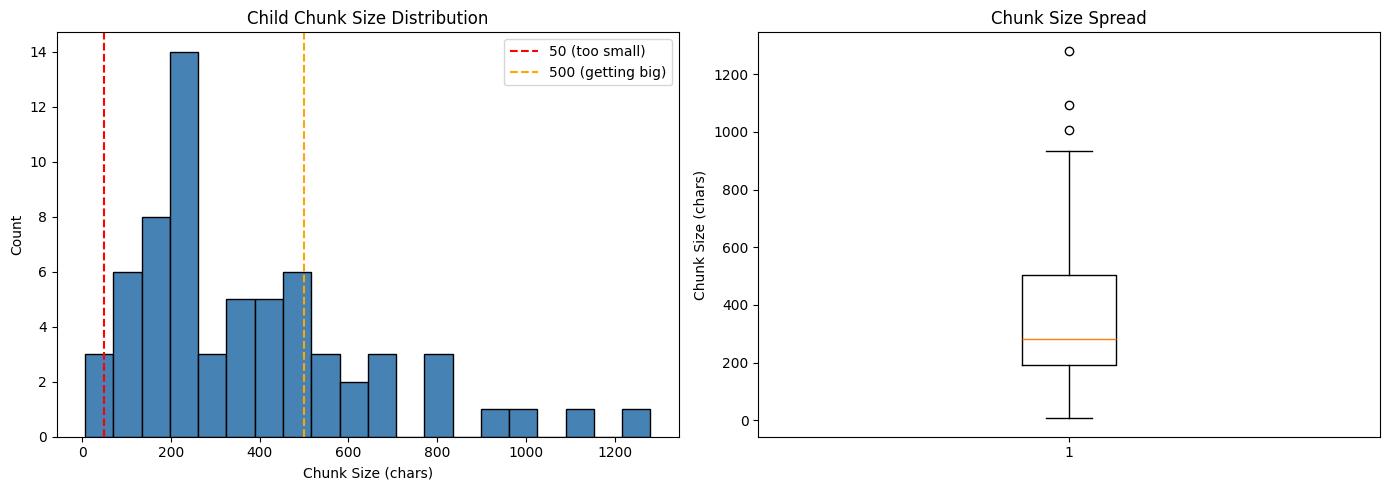


── Tiny Chunks (< 50 chars) ──
These are probably useless for search:

  [7 chars] "6

less"
  [21 chars] "This is like clearing"

── Huge Chunks (800+ chars) ──
These might be too broad for precise search:

  [805 chars] "WHY YOU DON’T FEEL LIKE DOING IT -

A short guide for You when your Vibe is gone. © 2025 by SHOGBIYE..."
  [1093 chars] "That person you need to call back... is an

open loop. Worrying about that upcoming test... is an

o..."
  [800 chars] "It is ﬁnite. It is

exhaustible. It can ﬁnish. Ehn, yes it can. The moment you truly understand this..."
  [1281 chars] "Your brain works the exact same way. The

reason

you

feel

scattered and

unproductive isn't that ..."
  [932 chars] "rest of your day will play out. If you wake up

and the ﬁrst thing you do is grab your phone

and sc..."
  [1005 chars] "they need to be done, yet you feel completely

drained of energy and motivation. You feel disappoint..."


In [13]:
# Cell 7b: Chunk Distribution Analysis

import matplotlib.pyplot as plt

sizes = [len(c.page_content) for c in all_children]

# ── Basic Stats ──
print(f"Total children:  {len(sizes)}")
print(f"Smallest:        {min(sizes)} chars")
print(f"Largest:         {max(sizes)} chars")
print(f"Average:         {sum(sizes)//len(sizes)} chars")
print(f"Median:          {sorted(sizes)[len(sizes)//2]} chars")

# ── Size Buckets ──
tiny = [s for s in sizes if s < 50]
small = [s for s in sizes if 50 <= s < 150]
good = [s for s in sizes if 150 <= s < 500]
large = [s for s in sizes if 500 <= s < 800]
huge = [s for s in sizes if s >= 800]

print(f"\n── Size Distribution ──")
print(f"Tiny   (< 50):     {len(tiny)}  ← probably useless")
print(f"Small  (50-150):   {len(small)}  ← maybe too small")
print(f"Good   (150-500):  {len(good)}  ← sweet spot")
print(f"Large  (500-800):  {len(large)}  ← fine")
print(f"Huge   (800+):     {len(huge)}  ← might be too big")

# ── Histogram ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(sizes, bins=20, edgecolor='black', color='steelblue')
axes[0].axvline(x=50, color='red', linestyle='--', label='50 (too small)')
axes[0].axvline(x=500, color='orange', linestyle='--', label='500 (getting big)')
axes[0].set_xlabel('Chunk Size (chars)')
axes[0].set_ylabel('Count')
axes[0].set_title('Child Chunk Size Distribution')
axes[0].legend()

# Box plot
axes[1].boxplot(sizes, vert=True)
axes[1].set_ylabel('Chunk Size (chars)')
axes[1].set_title('Chunk Size Spread')

plt.tight_layout()
plt.show()

# ── Show the problematic chunks ──
if tiny:
    print(f"\n── Tiny Chunks (< 50 chars) ──")
    print(f"These are probably useless for search:\n")
    for c in all_children:
        if len(c.page_content) < 50:
            print(f"  [{len(c.page_content)} chars] \"{c.page_content}\"")

if huge:
    print(f"\n── Huge Chunks (800+ chars) ──")
    print(f"These might be too broad for precise search:\n")
    for c in all_children:
        if len(c.page_content) >= 800:
            print(f"  [{len(c.page_content)} chars] \"{c.page_content[:100]}...\"")

── Children Per Parent ──
Total parents:       13
Min children/parent: 2
Max children/parent: 7
Avg children/parent: 5
Parents with only 1 child: 0
  (semantic chunker found no topic boundary)
  (child is basically identical to parent — redundant)


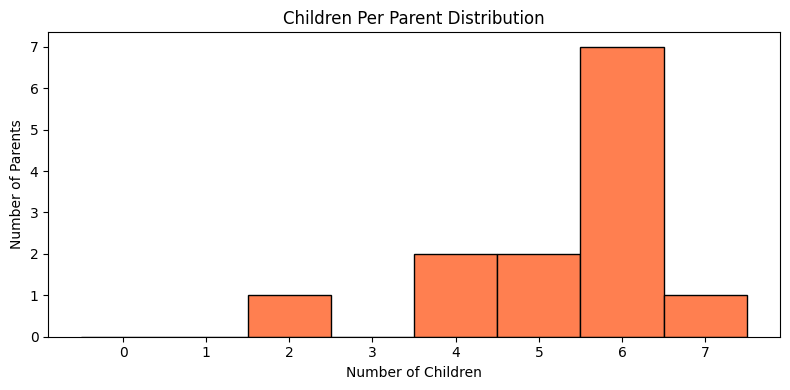

In [10]:
# Cell 7c: How many children does each parent have?

from collections import Counter

parent_child_counts = Counter()
parent_child_sizes = {}

for child in all_children:
    pid = child.metadata["parent_id"]
    parent_child_counts[pid] += 1
    
    if pid not in parent_child_sizes:
        parent_child_sizes[pid] = []
    parent_child_sizes[pid].append(len(child.page_content))

counts = list(parent_child_counts.values())

print(f"── Children Per Parent ──")
print(f"Total parents:       {len(counts)}")
print(f"Min children/parent: {min(counts)}")
print(f"Max children/parent: {max(counts)}")
print(f"Avg children/parent: {sum(counts)//len(counts)}")

# Parents with only 1 child (semantic chunker found no topic shift)
single_child = [pid for pid, count in parent_child_counts.items() if count == 1]
print(f"Parents with only 1 child: {len(single_child)}")
print(f"  (semantic chunker found no topic boundary)")
print(f"  (child is basically identical to parent — redundant)")

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(counts, bins=range(0, max(counts)+2), edgecolor='black', color='coral', align='left')
ax.set_xlabel('Number of Children')
ax.set_ylabel('Number of Parents')
ax.set_title('Children Per Parent Distribution')
ax.set_xticks(range(0, max(counts)+1))
plt.tight_layout()
plt.show()

In [15]:
# Cell 8: Upload to Pinecone (run ONCE)
# ⚠️ CLEAR FIRST to avoid duplicates

pc = Pinecone()
index = pc.Index(INDEX_NAME)

stats = index.describe_index_stats()
print(f"Current vectors in Pinecone: {stats['total_vector_count']}")

vectorstore = PineconeVectorStore.from_documents(
    all_children,
    embedding,
    index_name=INDEX_NAME
)

import time
time.sleep(5)  # wait for indexing

stats = index.describe_index_stats()
print(f"✅ Uploaded. Vectors now: {stats['total_vector_count']}")

Current vectors in Pinecone: 0
✅ Uploaded. Vectors now: 65


In [2]:
# Cell 9: Memory Setup

summary = ""
recent_messages = []
MAX_RECENT_PAIRS = 3

In [ ]:
# Cell 10: Chat Loop — Reformulate → Search → Answer → Update Memory


llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", temperature=0.3)

vectorstore = PineconeVectorStore.from_existing_index(
    index_name=INDEX_NAME,
    embedding=embedding
)

# ── Reformulation prompt ──
reformulation_prompt = ChatPromptTemplate.from_messages([
    ("system", """Rewrite the user's latest message as a standalone question that can be understood WITHOUT any conversation history. Resolve all pronouns. Do NOT answer the question, only rewrite it. If it's already standalone, return it as-is."""),
    ("human", """Conversation summary: {summary}

Recent messages:
{recent_messages}

User's latest message: {question}

Standalone question:""")
])

# ── Answer prompt ──
answer_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a knowledgeable document assistant. Answer questions based ONLY on the provided context. If the context doesn't contain enough information, say "I couldn't find information about that in your document." Be conversational but accurate. Do not make things up."""),
    ("human", """Context from the document:
---
{context}
---

Conversation so far: {summary}

Recent messages:
{recent_messages}

Question: {question}

Answer:""")
])

# ── Summary prompt ──
summary_prompt = ChatPromptTemplate.from_messages([
    ("system", "Summarize this conversation concisely. Capture key topics and facts. Keep it under 200 words."),
    ("human", """Previous summary: {old_summary}

New messages:
{new_messages}

Updated summary:""")
])

# ── Chains ──
reformulation_chain = reformulation_prompt | llm | StrOutputParser()
answer_chain = answer_prompt | llm | StrOutputParser()
summary_chain = summary_prompt | llm | StrOutputParser()

print("✅ Ready. Type 'quit' to exit, 'debug' to see memory, 'clear' to reset.\n")

while True:
    query = input("Human: ")
    
    if not query.strip():
        continue
    if query.lower() in ["quit", "exit", "q"]:
        break
    if query.lower() == "clear":
        summary = ""
        recent_messages = []
        print("🗑️ Memory cleared.\n")
        continue
    if query.lower() == "debug":
        print(f"\nSummary: {summary or '(empty)'}")
        print(f"Recent: {len(recent_messages)} messages")
        for msg in recent_messages:
            print(f"  {msg['role']}: {msg['content'][:80]}...")
        print()
        continue
    
    # ── Format recent messages as string ──
    recent_str = ""
    if recent_messages:
        recent_str = "\n".join(
            f"{'Human' if m['role'] == 'human' else 'AI'}: {m['content']}" 
            for m in recent_messages
        )
    
    # ── Step 1: Reformulate ──
    if summary or recent_messages:
        search_query = reformulation_chain.invoke({
            "question": query,
            "summary": summary or "No previous conversation.",
            "recent_messages": recent_str or "No recent messages.",
        })
    else:
        search_query = query
    
    # ── Step 2: Search children ──
    child_results = vectorstore.similarity_search(search_query, k=5)
    
    # ── Step 3: Get parents ──
    parent_ids = []
    seen_pids = set()
    for child in child_results:
        pid = child.metadata.get("parent_id")
        if pid and pid not in seen_pids:
            parent_ids.append(pid)
            seen_pids.add(pid)
    
    parent_texts = []
    for pid in parent_ids:
        if pid in parent_store:
            parent_texts.append(parent_store[pid]["content"])
    
    context = "\n\n---\n\n".join(parent_texts) if parent_texts else "No relevant context found."
    
    # ── Step 4: Generate answer ──
    answer = answer_chain.invoke({
        "context": context,
        "question": query,
        "summary": summary or "No previous conversation.",
        "recent_messages": recent_str or "No recent messages.",
    })
    
    # ── Step 5: Display ──
    print(f"\nAI: {answer}")
    print(f"  🔍 Searched: \"{search_query}\"")
    print(f"  📄 Parents found: {len(parent_texts)}")
    
    # ── Step 6: Update memory ──
    recent_messages.append({"role": "human", "content": query})
    recent_messages.append({"role": "ai", "content": answer})
    
    # ── Step 7: Summarize if memory too long ──
    if len(recent_messages) > MAX_RECENT_PAIRS * 2:
        # Messages to summarize
        to_summarize = recent_messages[:-(MAX_RECENT_PAIRS * 2)]
        to_keep = recent_messages[-(MAX_RECENT_PAIRS * 2):]
        
        new_messages_str = "\n".join(
            f"{'Human' if m['role'] == 'human' else 'AI'}: {m['content']}" 
            for m in to_summarize
        )
        
        summary = summary_chain.invoke({
            "old_summary": summary or "No previous summary.",
            "new_messages": new_messages_str,
        })
        
        recent_messages = to_keep
        print(f"  📝 Memory summarized.")
    
    print()

✅ Ready. Type 'quit' to exit, 'debug' to see memory, 'clear' to reset.


AI: I couldn't find information about that in your document.
  🔍 Searched: "Why don't I have vibes?"
  📄 Parents found: 0

